# Approach foundation:

Based on the assumption of an image intensity remaining constant and that objects show patterns.

The aim is to find matches between 2 images looking for patterns or sets of interesting pixels.

Then the local difference of brightness intensity for a point can be expressed as the brightness increase per direction times the movement in each direction.

$$I_x(x, y) /cdot u + I_y(x, y) /cdot v = -I_t(x, y)$$


But one sole point does not provide information for estimation of the whole movement, that is why an neighborhood of pixels is explored.

The solution for the Lucas-Kanade optical flow problem can be expressed as a least squares problem. Define the following matrices and vectors:

- /(A/) represents the matrix of displacement terms:
  $$A = /begin{bmatrix}
  I_x(x_1, y_1) & I_y(x_1, y_1) //
  I_x(x_2, y_2) & I_y(x_2, y_2) //
  /vdots & /vdots //
  I_x(x_n, y_n) & I_y(x_n, y_n) //
  /end{bmatrix}$$

- /(b/) represents the vector of brightness difference terms:
  $$b = /begin{bmatrix}
  I_t(x_1, y_1) //
  I_t(x_2, y_2) //
  /vdots //
  I_t(x_n, y_n) //
  /end{bmatrix}$$

The goal is to find the flow vector /(/begin{bmatrix} u & v /end{bmatrix}^T/) that minimizes the error. Using the MP pseudo-inverse, the solution is given by:

$$
/begin{bmatrix} u // v /end{bmatrix} = (A^T A)^{-1} A^T b
$$


Open and import the modules

In [125]:
import cv2
import numpy as np

BACKSTEP = False
CYLINDER = False
DNS = False
SQG = False
UNIFORM = False
CAR = True

if BACKSTEP:
    # Load image pair
    print("Selected images: BACKSTEP")
    frame1 = cv2.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset/backstep_test/backstep_Re800_00001_img1.tif', 0)
    frame2 = cv2.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset/backstep_test/backstep_Re800_00001_img2.tif', 0)

if CYLINDER:
    # Load image pair
    print("Selected images: CYLINDER")
    frame1 = cv2.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset/cylinder_test/cylinder_Re40_00001_img1.tif', 0)
    frame2 = cv2.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset/cylinder_test/cylinder_Re40_00001_img2.tif', 0)

if DNS:
    # Load image pair
    print("Selected images: DNS")
    frame1 = cv2.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset/DNS_test/DNS_turbulence_00001_img1.tif', 0)
    frame2 = cv2.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset/DNS_test/DNS_turbulence_00001_img2.tif', 0)

if SQG:
    # Load image pair
    print("Selected images: SQG")
    frame1 = cv2.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset/DNS_test/DNS_turbulence_00001_img1.tif', 0)
    frame2 = cv2.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset/DNS_test/DNS_turbulence_00001_img2.tif', 0)

if UNIFORM:
    # Load image pair
    print("Selected images: UNIFORM")
    frame1 = cv2.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset/uniform_test/uniform_00001_img1.tif', 0)
    frame2 = cv2.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/PIV_dataset/uniform_test/uniform_00001_img2.tif', 0)

if CAR:
    # Load image pair
    print("Selected images: CAR")
    frame1 = cv2.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/general_test/car1.jpg', 0)
    frame2 = cv2.imread('C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/general_test/car2.jpg', 0)

# Convert to float32 for better accuracy
frame1 = frame1.astype(np.float32)
frame2 = frame2.astype(np.float32)

Selected images: CAR


Compute the spatial derivatives of the image intensity

In [126]:
I_x = cv2.Sobel(frame1, cv2.CV_64F, 1, 0, ksize=5)
I_y = cv2.Sobel(frame1, cv2.CV_64F, 0, 1, ksize=5)

Set the local neighborhood to apply the local smoothness condition from Lucas-Kanade, approach Optical Flow

In [127]:
window_size = 3
half_window = window_size // 2

In [132]:
def calculate_optical_flow(I_x, I_y, frame1, frame2, half_window):
    optical_flow = np.zeros((frame1.shape[0], frame1.shape[1], 2), dtype=np.float32)
    
    # Apply padding to the input arrays
    padding = ((half_window, half_window), (half_window, half_window))
    padded_I_x = np.pad(I_x, padding, mode='constant')
    padded_I_y = np.pad(I_y, padding, mode='constant')
    padded_frame1 = np.pad(frame1, padding, mode='constant')
    padded_frame2 = np.pad(frame2, padding, mode='constant')
    
    for i in range(half_window, frame1.shape[0] - half_window):
        for j in range(half_window, frame1.shape[1] - half_window):
           I_x_window = padded_I_x[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1]
           I_y_window = padded_I_y[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1]
            
           I_t = frame2[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1] - frame1[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1]
           I_t = I_t.reshape(half_window*2+1,-1)
        
           A = np.column_stack((I_x_window.flatten(), I_y_window.flatten()))
           A_pseudo_inv = np.linalg.pinv(A)
        
           optical_flow_vector = np.dot(A_pseudo_inv, -I_t)
           # Store the optical flow vector components in the appropriate locations
           optical_flow[i, j] = np.squeeze(optical_flow_vector.reshape(2, 1))
            
    return optical_flow


In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (a single vector for each point, where each point has both U and V components)
optical_flow = calculate_optical_flow(I_x, I_y, frame1, frame2, half_window)

# Create a grid of coordinates for the quiver plot
x, y = np.meshgrid(np.arange(optical_flow.shape[1]), np.arange(optical_flow.shape[0]))

# Subsample the data to show every 5th pixel
subsample_factor = 5
x_subsampled = x[::subsample_factor, ::subsample_factor]
y_subsampled = y[::subsample_factor, ::subsample_factor]
U_subsampled = optical_flow[::subsample_factor, ::subsample_factor, 0]
V_subsampled = optical_flow[::subsample_factor, ::subsample_factor, 1]

# Create the quiver plot with subsampled data
plt.figure(figsize=(8, 8))
plt.quiver(x_subsampled, y_subsampled, U_subsampled, V_subsampled, angles='xy', scale_units='xy', scale=1, color='b')


M = np.hypot(U_subsampled, V_subsampled)
Q = plt.quiver(x_subsampled, y_subsampled, U_subsampled, V_subsampled, M, units='x', pivot='tip', width=0.022,
               scale=1 / 0.15)
qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$1 /frac{m}{s}$', labelpos='E',
                   coordinates='figure')
plt.scatter(x_subsampled, y_subsampled, color='0.5', s=1)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dense Velocity Field (Subsampled)')

# Show the plot
plt.show()

ValueError: shapes (2,9) and (3,3) not aligned: 9 (dim 1) != 3 (dim 0)

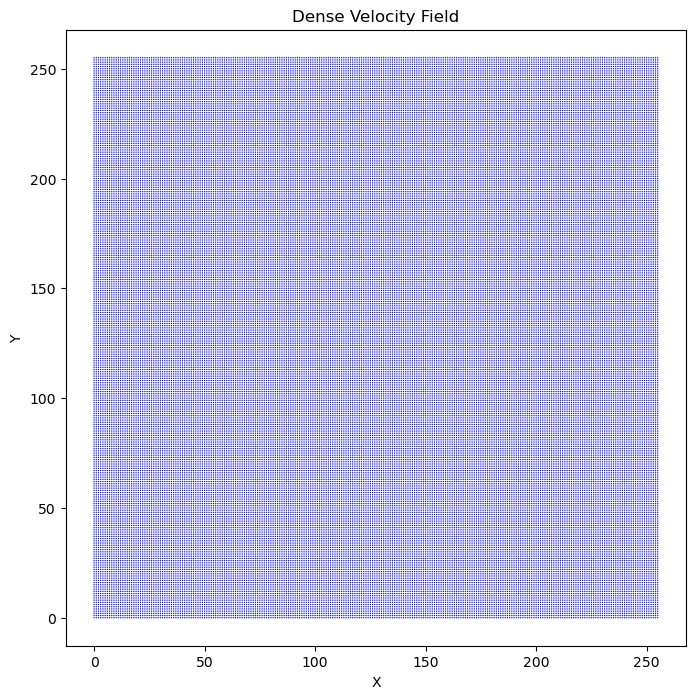

In [ ]:
optical_flow = calculate_optical_flow(I_x, I_y, frame1, frame2, half_window)

# Display the optical flow vectors using quiver plot
import matplotlib.pyplot as plt

# Create a grid of coordinates for the quiver plot
x, y = np.meshgrid(np.arange(optical_flow.shape[1]), np.arange(optical_flow.shape[0]))

# Extract the U and V components from the velocity field
U = optical_flow[:, :, 0]
V = optical_flow[:, :, 1]

# Create the quiver plot
plt.figure(figsize=(8, 8))
plt.quiver(x, y, U, V, angles='xy', scale_units='xy', scale=1, color='b')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dense Velocity Field')

# Show the plot
plt.show()

___

In [136]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import convolve as convolution
import os

In [137]:
def show_image(name, image):
    if image is None:
        return

    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [138]:
def get_magnitude(u, v):
    scale = 3
    sum = 0.0
    counter = 0.0

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            counter += 1
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            sum += magnitude

    mag_avg = sum / counter

    return mag_avg

In [139]:
def draw_quiver(u,v,beforeImg):
    scale = 3
    ax = plt.figure().gca()
    ax.imshow(beforeImg, cmap = 'gray')

    magnitudeAvg = get_magnitude(u, v)

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            #draw only significant changes
            if magnitude > magnitudeAvg:
                ax.arrow(j,i, dx, dy, color = 'red')

    plt.draw()
    plt.show()

In [141]:
def get_derivatives(img1, img2):
    #derivative masks
    x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
    y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
    t_kernel = np.ones((2, 2)) * 0.25

    fx = convolution(img1,x_kernel) + convolution(img2,x_kernel)
    fy = convolution(img1, y_kernel) + convolution(img2, y_kernel)
    ft = convolution(img1, -t_kernel) + convolution(img2, t_kernel)

    return [fx,fy, ft] 

In [142]:
def computeHS(name1, name2, alpha, delta):
    #path = os.path.join(os.path.dirname(__file__), 'test images')
    beforeImg = cv2.imread(name1)
    afterImg = cv2.imread(name2)

    if beforeImg is None:
        raise NameError("Can't find image: \"" + name1 + '\"')
    elif afterImg is None:
        raise NameError("Can't find image: \"" + name2 + '\"')

    beforeImg = cv2.imread(os.path.join(path, name1), cv2.IMREAD_GRAYSCALE).astype(float)
    afterImg = cv2.imread(os.path.join(path, name2), cv2.IMREAD_GRAYSCALE).astype(float)

    #removing noise
    beforeImg  = cv2.GaussianBlur(beforeImg, (5, 5), 0)
    afterImg = cv2.GaussianBlur(afterImg, (5, 5), 0)

    # set up initial values
    u = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    v = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    fx, fy, ft = get_derivatives(beforeImg, afterImg)
    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                            [1 / 6, 0, 1 / 6],
                            [1 / 12, 1 / 6, 1 / 12]], float)
    iter_counter = 0
    while True:
        iter_counter += 1
        u_avg = convolution(u, avg_kernel)
        v_avg = convolution(v, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.linalg.norm(u - prev, 2)
        #converges check (at most 300 iterations)
        if  diff < delta or iter_counter > 300:
            # print("iteration number: ", iter_counter)
            break

    draw_quiver(u, v, beforeImg)

    return [u, v]

In [143]:
path1 = 'C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/general_test/car1.jpg'
path2 = 'C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/raw/general_test/car2.jpg'
u,v = computeHS(path1, path2, alpha = 15, delta = 10**-1)

NameError: name '__file__' is not defined

In [ ]:
def calculate_optical_flow(I_x, I_y, frame1, frame2, half_window):
    optical_flow = np.zeros((frame1.shape[0], frame1.shape[1], 2), dtype=np.float32)
    
    for i in range(half_window, frame1.shape[0] - half_window):
        for j in range(half_window, frame1.shape[1] - half_window):
            I_x_window = I_x[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1]
            I_y_window = I_y[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1]
            
            I_t = frame2[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1] - frame1[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1]
            I_t = I_t.reshape(25,-1)
            A = np.column_stack((I_x_window.flatten(), I_y_window.flatten()))
            A_pseudo_inv = np.linalg.pinv(A)
            optical_flow_vector = np.dot(A_pseudo_inv, -I_t)
            # Store the optical flow vector components in the appropriate locations
            optical_flow[i, j] = np.squeeze(optical_flow_vector.reshape(2, 1))
            
    return optical_flow